
# THE DEPENDENCIES

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential,load_model
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense
from claptcha import Claptcha
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os,os.path
import datetime
import imutils
import random
import string
import glob
import cv2
import tensorflow
%load_ext tensorboard
%matplotlib inline




# CREATING CAPTCHAS RANDOMLY

In [2]:
def randomString():
    rndLetters = (random.choice(string.ascii_uppercase+string.digits) for _ in range(4))
    return "".join(rndLetters)
def match(str1, str2): 
    c, j = 0, 0
    for i in str1:    
        if str2.find(i)>= 0 and j == str1.find(i): 
            c += 1
        j += 1
    if c == 3 :
        return 0.75
    elif c == 2 :
        return 0.5
    elif c == 4 :
        return 1
    else :
        return 0

In [3]:
captcha_text = []
n = 2000
for i in range(1,n):
    text = randomString()
    c = Claptcha(text, "FreeMono.ttf", (150,90),
             resample=Image.BICUBIC, noise=0.2)
    c.margin = (25,25)
    text, _ = c.write('Generated_captchas\\'+text+'.png')
    captcha_text.append(text)

C:\Users\hp\AppData\Local\Temp\ipykernel_12820\2882395662.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resample=Image.BICUBIC, noise=0.2)


In [4]:
a = pd.Series(captcha_text)
a.to_csv('Captcha_label.csv')

# PREPROCESSING THE GENERATED CAPTCHAS

In [5]:
captchas_folder = "Generated_captchas/"
preprocessed_captchas = "Preprocessed/"

In [6]:
def saveimage(letter_text,letter_image):
    path = os.path.join(preprocessed_captchas, letter_text)
    if not os.path.exists(path):
        os.makedirs(path)
    p = os.path.join(path, str(random.randint(1,10000))+".png")
    cv2.imwrite(p, letter_image)

In [7]:
captcha_images=  glob.glob(os.path.join(captchas_folder, "*"))

# SAMPLE IMAGE PREPROCESSING AND DRAWING COUNTERS

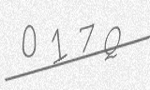

In [8]:
image = cv2.imread(captcha_images[3])
Image.fromarray(image)

In [9]:
image.shape

(90, 150, 3)

In [10]:
s = Image.open(captcha_images[1])

In [11]:
s.getpixel((2,5))

(240, 240, 240)

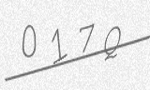

In [12]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
Image.fromarray(gray)

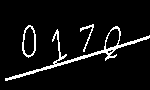

In [13]:
ret,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
Image.fromarray(thresh)

In [14]:



contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)


image_copy = gray.copy()

cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

                

cv2.imshow('None approximation', image_copy)

cv2.waitKey(0)
cv2.imwrite('contours_none_image1.jpg', image_copy)
cv2.destroyAllWindows()


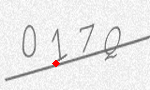

In [15]:
img = cv2.drawContours(image,contours,1,(255,0,0),3)
Image.fromarray(img)

# Exploring the Image 

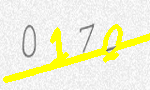

In [16]:
img = cv2.drawContours(image,contours,0,(255,255,0),3)
Image.fromarray(img)

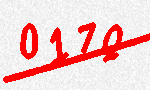

In [17]:
img = cv2.drawContours(image,contours,-1,(255,0,0),3)
Image.fromarray(img)

In [18]:
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    print(x,y,w,h)

5 26 145 55
54 62 4 3
107 49 7 5
105 28 15 22
22 25 14 33
23 26 12 30
80 24 14 28


In [19]:
Image.fromarray(thresh[0:thresh.shape[0],10:40])

# SAVING PREPROCESSED IMAGES

In [20]:
for file in captcha_images:
    mystr = file.split('/')
    value = mystr[-1].split('\\')[1].split('.')[0]
    image = cv2.imread(file)
    gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    image = cv2.threshold(gray_scale,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    slicedImage = image[0:image.shape[0],10:40]
    letter = value[0]
    saveimage(letter,slicedImage) 
    slicedImage = image[0:image.shape[0],40:70]
    letter = value[1]
    saveimage(letter,slicedImage)
    slicedImage = image[0:image.shape[0],70:100]
    letter = value[2]
    saveimage(letter,slicedImage)
    slicedImage = image[0:image.shape[0],100:130]
    letter = value[3]
    saveimage(letter,slicedImage)

# GETTING STARTED WITH TRAINING PHASE

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
training_set = train_datagen.flow_from_directory('Preprocessed/',
target_size = (32, 32),
class_mode = 'categorical',color_mode='grayscale')

Found 7895 images belonging to 36 classes.


In [23]:
training_set.classes

array([ 0,  0,  0, ..., 35, 35, 35])

# THE NEURAL NETWORK ARCHITECTURE

In [24]:
classifier = Sequential()
classifier.add(Conv2D(32, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))
classifier.add(Conv2D(32, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 500, activation = 'relu'))
classifier.add(Dense(units = 36, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [28]:





classifier.fit(training_set,steps_per_epoch=5,epochs=50, callbacks=[tensorboard_callback])

Epoch 1/50
5/5 [==============================] - 1s 226ms/step - loss: 0.8705 - accuracy: 0.7250
Epoch 2/50
5/5 [==============================] - 1s 252ms/step - loss: 0.9470 - accuracy: 0.7188
Epoch 3/50
5/5 [==============================] - 1s 199ms/step - loss: 0.9350 - accuracy: 0.7000
Epoch 4/50
5/5 [==============================] - 1s 192ms/step - loss: 0.8030 - accuracy: 0.7625
Epoch 5/50
5/5 [==============================] - 1s 195ms/step - loss: 1.0449 - accuracy: 0.6750
Epoch 6/50
5/5 [==============================] - 1s 202ms/step - loss: 1.1743 - accuracy: 0.6438
Epoch 7/50
5/5 [==============================] - 1s 207ms/step - loss: 0.8015 - accuracy: 0.7250
Epoch 8/50
5/5 [==============================] - 1s 202ms/step - loss: 0.8879 - accuracy: 0.7563
Epoch 9/50
5/5 [==============================] - 1s 176ms/step - loss: 0.9736 - accuracy: 0.7125
Epoch 10/50
5/5 [==============================] - 1s 182ms/step - loss: 0.8178 - accuracy: 0.7625
Epoch 11/50
5/5 [==

In [29]:
#!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 20640), started 0:14:45 ago. (Use '!kill 20640' to kill it.)

In [30]:
d = training_set.class_indices
print(d)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35}


# PRESERVING THE TRAINED MODEL

In [31]:
classifier.save('captchaclassifier_final.hdf5')

# LOADING MODEL AND DEPLOYMENT

In [32]:
captcha_model = load_model('captchaclassifier_final.hdf5')

In [37]:
captcha_image_files =  glob.glob(os.path.join('Test_data\\Test\\', "*"))

In [38]:
dict_class = {v:k for k,v in d.items()}
print(captcha_image_files)
print(dict_class)

['Test_data\\Test\\37KN.png', 'Test_data\\Test\\50X8.png', 'Test_data\\Test\\A8HG.png', 'Test_data\\Test\\AE7G.png', 'Test_data\\Test\\BRCG.png', 'Test_data\\Test\\CZ01.png', 'Test_data\\Test\\DY8C.png', 'Test_data\\Test\\FYVR.png', 'Test_data\\Test\\G8O9.png', 'Test_data\\Test\\GLDJ.png', 'Test_data\\Test\\H90P.png', 'Test_data\\Test\\JB4A.png', 'Test_data\\Test\\OUVM.png', 'Test_data\\Test\\OW7M.png', 'Test_data\\Test\\Q29N.png', 'Test_data\\Test\\Q34F.png', 'Test_data\\Test\\Q5BK.png', 'Test_data\\Test\\Q5C7.png', 'Test_data\\Test\\Q5EN.png', 'Test_data\\Test\\Q5TM.png', 'Test_data\\Test\\Q69L.png', 'Test_data\\Test\\Q7EP.png', 'Test_data\\Test\\Q7HO.png', 'Test_data\\Test\\Q7O5.png', 'Test_data\\Test\\Q7WC.png', 'Test_data\\Test\\Q817.png', 'Test_data\\Test\\Q97J.png', 'Test_data\\Test\\QA03.png', 'Test_data\\Test\\QA9Y.png', 'Test_data\\Test\\QAO8.png', 'Test_data\\Test\\QB4X.png', 'Test_data\\Test\\QCD3.png', 'Test_data\\Test\\QCDW.png', 'Test_data\\Test\\QDAB.png', 'Test_data\\T

# MAPPING THE LABELS WITH VALUES

In [39]:
def find_value(pred):
    count =0
    for i in pred[0] :
        count+=1
        if i >= 0.8:
            return dict_class[count-1]


# Prediction logic for the test data

In [40]:
count=0.0
for file in captcha_image_files:
    combine = []
    mystr = file.split('\\')
    value1 = mystr[-1].split('.')[0]
    image = cv2.imread(file)
    gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.threshold(gray_scale,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    slicedImage = image[0:90,10:40]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img = np.expand_dims(img,axis=0)
    
    pred = captcha_model.predict(img)
    
    print((pred[0]))
    
    
    first = find_value(pred)
    print(first)
    combine.append(first)
     
    ##
    slicedImage = image[0:90,40:70]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img = np.expand_dims(img,axis=0)
    
    
    pred = captcha_model.predict(img)
    
    print((pred[0]))
    
    
    second = find_value(pred)
    print(second)
    combine.append(second)

    ##
    slicedImage = image[0:90,70:100]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img = np.expand_dims(img,axis=0)
    
    pred = captcha_model.predict(img)
    
    print((pred[0]))
    
    
    third = find_value(pred)
    print(third)
    combine.append(third)
    print(combine)
    
    ##
    slicedImage = image[0:90,100:130]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img= np.expand_dims(img,axis=0)
    pred = captcha_model.predict(img)
    
    print((pred[0]))
    
    
    fourth = find_value(pred)
    print(fourth)
    combine.append(fourth)
    print(combine)
    
    
    predict = ''.join(combine)
    print(predict)
    print(value1)
    print("------------")
    result = match(value1,predict)
    if result == 0.75 :
        print("String Matched by 75%")
    elif result == 0.5 :
        print("String Matched by 50%")
    elif result == 1 :
        print("String Matched by 100%")
    else :
        print("String havent matched")
    count+=match(value1,predict)
    print(match(value1,predict))
    '''if value1 == predict:
        count+=1'''

1/1 [==============================] - 0s 256ms/step
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3
1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
1/1 [==============================] - 0s 39ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
K
['3', '4', 'K']
1/1 [==============================] - 0s 39ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
N
['3', '4', 'K', 'N']
34KN
37KN
------------
String Matched by 75%
0.75
1/1 [==============================] - 0s 39ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.8372848e-13 0.0000000e+00 0.0000000e+00 0.0000000e+00 0

1/1 [==============================] - 0s 35ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
P
['B', 'L', 'P']
1/1 [==============================] - 0s 55ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
V
['B', 'L', 'P', 'V']
BLPV
GLDJ
------------
String havent matched
0
1/1 [==============================] - 0s 51ms/step
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 9.283162e-16 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
M
1/1 [==============================] - 0s 44ms/step
[0.

1/1 [==============================] - 0s 42ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
N
['Q', '5', '8', 'N']
Q58N
Q5EN
------------
String Matched by 75%
0.75
1/1 [==============================] - 0s 56ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
N
1/1 [==============================] - 0s 50ms/step
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 1.000000e+00 0.000000e+00 0.000000e+00 8.268761e-36 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
5
1/1 [==============================] - 0s 42ms/step
[0. 0. 0. 0. 1. 

1/1 [==============================] - 0s 50ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 9.9999988e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.4795629e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
7
['Q', 'A', 'V', '7']
QAV7
QA03
------------
String Matched by 50%
0.5
1/1 [==============================] - 0s 41ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8
1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
H
1/1 [============================

1/1 [==============================] - 0s 61ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
['Q', 'E', '1']
1/1 [==============================] - 0s 36ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
['Q', 'E', '1', '1']
QE11
QFLL
------------
String havent matched
0
1/1 [==============================] - 0s 43ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Q
1/1 [==============================] - 0s 35ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
G
1/1 [==============================] - 0s 36ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
['Q', 'G', '2']
1/1 [==============================] - 0s 37ms/step
[0.000000e+00 0.000000e

1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9
1/1 [==============================] - 0s 34ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
N
1/1 [==============================] - 0s 47ms/step
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
['9', 'N', '4']
1/1 [==============================] - 0s 35ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
['9', 'N', '4', '2']
9N42
QI47
------------
String havent matched
0
1/1 [==============================] - 0s 34ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Q
1/1 [==============================] - 0s 35ms/step
[0.000000e+00 7.378983e-12 0.000000e+00

1/1 [==============================] - 0s 34ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
V
1/1 [==============================] - 0s 51ms/step
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 6.462426e-30 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]
V
['W', 'V', 'V']
1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
V
['W', 'V', 'V', 'V']
WVVV
QLTY
------------
String havent matched
0
1/1 [==============================] - 0s 37ms/step
[0.

1/1 [==============================] - 0s 45ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
V
['Q', '8', '1', 'V']
Q81V
QS17
------------
String Matched by 50%
0.5
1/1 [==============================] - 0s 50ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Q
1/1 [==============================] - 0s 39ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
T
1/1 [==============================] - 0s 33ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
X
['Q', 'T', 'X']
1/1 [==============================] - 0s 42ms/step
[0.000000e+00 3.032188e-28 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.0

1/1 [==============================] - 0s 36ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
1/1 [==============================] - 0s 33ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
C
['A', '2', 'C']
1/1 [==============================] - 0s 39ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
P
['A', '2', 'C', 'P']
A2CP
R2CP
------------
String Matched by 75%
0.75
1/1 [==============================] - 0s 45ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
R
1/1 [==============================] - 0s 40ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
1/1 [==============================] - 0s 33ms/step
[0.0000000e+00 1.0000000e+00 0.00000

1/1 [==============================] - 0s 51ms/step
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6
1/1 [==============================] - 0s 44ms/step
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
['H', '6', '0']
1/1 [==============================] - 0s 38ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
['H', '6', '0', '1']
H601
R6QT
------------
String havent matched
0
1/1 [==============================] - 0s 33ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.9341727e-22 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00

1/1 [==============================] - 0s 43ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
['Y', 'H', '0', '2']
YH02
YHO2
------------
String Matched by 75%
0.75
1/1 [==============================] - 0s 34ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Y
1/1 [==============================] - 0s 44ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
X
['Y', '1', 'X']
1/1 [==============================] - 0s 45ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Q
['Y', '1', 'X', 'Q']
Y1XQ
YIFO
------------
String havent matched
0
1/1 [===============

1/1 [==============================] - 0s 41ms/step
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Q
1/1 [==============================] - 0s 41ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
W
['4', 'Q', 'W']
1/1 [==============================] - 0s 36ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E
['4', 'Q', 'W', 'E']
4QWE
YQWE
------------
String Matched by 75%
0.75
1/1 [==============================] - 0s 38ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Y
1/1 [==============================] - 0s 40ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

1/1 [==============================] - 0s 45ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Y
1/1 [==============================] - 0s 47ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
X
1/1 [==============================] - 0s 48ms/step
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
['Y', 'X', '0']
1/1 [==============================] - 0s 55ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
P
['Y', 'X', '0', 'P']
YX0P
YX0P
------------
String Matched by 100%
1
1/1 [==============================] - 0s 45ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Y
1/1 [==============================] - 0s 41ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

1/1 [==============================] - 0s 46ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F
['4', '9', 'F']
1/1 [==============================] - 0s 40ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O
['4', '9', 'F', 'O']
49FO
Z9FO
------------
String Matched by 75%
0.75


# RESULTS EVALUATION

In [41]:
Accuracy = count/len(captcha_image_files)
print(Accuracy)

0.603448275862069
